In [3]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pytorch_lightning as pl
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np

import json
import os
import glob

import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_ROOT = "../data/SensorData/"
user_file_prefix = "User"

TRAIN_FOLDER_PATH = os.path.join(DATA_ROOT, "train")
TEST_FOLDER_PATH = os.path.join(DATA_ROOT, "test")
os.makedirs(TRAIN_FOLDER_PATH, exist_ok=True)
os.makedirs(TEST_FOLDER_PATH, exist_ok=True)

data_files = sorted(glob.glob(os.path.join(DATA_ROOT, f"{user_file_prefix}*.csv")))
print(data_files)

['../data/SensorData/User00.csv', '../data/SensorData/User01.csv', '../data/SensorData/User02.csv', '../data/SensorData/User03.csv', '../data/SensorData/User04.csv', '../data/SensorData/User05.csv', '../data/SensorData/User06.csv', '../data/SensorData/User07.csv', '../data/SensorData/User08.csv', '../data/SensorData/User09.csv', '../data/SensorData/User10.csv', '../data/SensorData/User11.csv', '../data/SensorData/User12.csv', '../data/SensorData/User13.csv', '../data/SensorData/User14.csv', '../data/SensorData/User15.csv']


## Test with User00.csv

In [5]:
def segment(data_df, label_list, Window_size = 200, over_lap = 0.5, margin = 200):
    data_df_index_list = []
    index_label_list = []
    
    overlap_data = Window_size * over_lap

    index = 0
    loop = 0
    current_label = None
    
    while index < data_df.shape[0]:
        if index + Window_size >= data_df.shape[0]: break
    
        if current_label is not None and data_df['label'][index] == current_label:
            index += 1
            continue
            
        if pd.isna(data_df['label'][index]):
            index = index + 1
            continue

        count = 0
        while count < margin:
            count, index = count + 1, index + 1

        if index + Window_size >= data_df.shape[0]: break
        current_label = data_df.loc[index, 'label']

        while not pd.isna(data_df['label'][index + Window_size]) and data_df['label'][index + Window_size] == current_label:
#                 signal_data = data_df.iloc[index: index + Window_size, :]

            # Each data will be at size column(6 x 5 = 30) x Window_size
            # achieved by `data_df.loc[index: index + self.Window_size, :]` for index in data_df_index_list.
            # Data label will be `data_df.loc[index + self.Window_size, "label"]` for index in data_df_index_list.
            data_df_index_list.append(index)
            index = index + Window_size

            # add label of the last row of sequence
            index_label_list.append(data_df['label'][index])

            index = index - int(overlap_data)
            if index + Window_size >= data_df.shape[0]: break
                
    return data_df_index_list, index_label_list

In [6]:
data_df = pd.read_csv(data_files[0])
data_df

,accXA,accYA,accZA,agsXA,agsYA,agsZA,accXB,accYB,accZB,agsXB,...,agsXF,agsYF,agsZF,accXG,accYG,accZG,agsXG,agsYG,agsZG,label
0,10581,-2102,-3659,989,-647,-424,9780,86,-394,721,...,-3195,8792,-1487,9624,1114,-1587,-5325,-6494,2206,0
1,10637,-2021,-3691,1000,-636,-445,9788,164,-304,801,...,-3317,9067,-1737,9741,884,-1365,-5870,-6179,1907,0
2,10637,-2048,-3596,1024,-639,-473,9851,149,-443,882,...,-3164,8945,-2024,10022,523,-1133,-5371,-5702,1629,0
3,10566,-2084,-3522,1042,-622,-493,9897,278,-390,943,...,-3298,8573,-2359,10032,52,-833,-4236,-5112,1418,0
4,10546,-2075,-3481,1082,-616,-500,9854,283,-365,993,...,-3396,8865,-2390,10139,10,-699,-3126,-4431,1249,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31638,2390,-6623,4226,132,-157,-135,2346,7266,6094,-12,...,-298,1201,-1585,-66,-2335,-10501,-245,-74,-46,9
31639,2407,-6682,4282,35,-181,-126,2434,7327,6004,-45,...,-359,1304,-1579,-142,-2332,-10398,-207,-53,-52,9
31640,2414,-6682,4257,-58,-158,-129,2358,7271,6087,6,...,-481,1469,-1585,-103,-2298,-10464,-226,-45,-47,9
31641,2446,-6762,4208,-62,-151,-141,2329,7310,6067,54,...,-615,1628,-1664,-142,-2298,-10430,-218,-24,-47,9


In [7]:
data_df["label"].value_counts()

9    6571
8    5337
7    3172
2    3025
5    2577
4    2461
3    2403
6    2185
0    2079
1    1833
Name: label, dtype: int64

In [8]:
# important

label_list = ['歩行(平地)',
 '歩行(階段)',
 'ベッド上での起き上がり',
 'ベッド椅子間の乗り移り(立つ)',
 'ベッド椅子間の乗り移り(立たない)',
 '立ち座り',
 '座位保持・座位バランス',
 '立位保持・立位バランス',
 '関節可動域増大訓練(肩)',
 '関節可動域増大訓練(股関節)']

label_dict = dict(enumerate(label_list))

In [9]:
# important
eng_label_dict = dict(zip(
    label_list,
    ['Walking', 'Upstair', 'Bed_Standup', 'Change_Bed', 'Change_Bed_Standup', 'Sit_Down', 'Sit', 'Stand', 'Shoulder_Exercise', 'Hip_Exercise']
))

eng_label_list = [eng_label_dict[i] for i in label_list]

In [10]:
window_size = 256
data_df_index_list, index_label_list = segment(data_df, label_list, Window_size=window_size, over_lap=3/4)

In [11]:
data_list = []
for index, label_number in zip(data_df_index_list, index_label_list):
    x = data_df.iloc[index: index + window_size, :].drop(["label"], axis=1).values
    data_list.append(x)
data_list = np.array(data_list)

In [12]:
data_list.shape

(430, 256, 42)

In [13]:
sc = StandardScaler()

data_num, window_size, feature_num = data_list.shape
features_reshape = data_list.reshape(-1, feature_num)
features_norm = sc.fit_transform(features_reshape)

# convert back t feature size
features = features_norm.reshape(data_num, window_size, feature_num)

## create function to load feature from 1 csv file

In [14]:
def load_csv_data(csv_file_path):
    window_size = 256
    data_df = pd.read_csv(csv_file_path)
    data_df_index_list, index_label_list = segment(data_df, label_list, Window_size=window_size, over_lap=3/4)
    
    data_list = []
    for index, label_number in zip(data_df_index_list, index_label_list):
        x = data_df.iloc[index: index + window_size, :].drop(["label"], axis=1).values
        data_list.append(x)
    data_list = np.array(data_list)
    
    sc = StandardScaler()

    data_num, window_size, feature_num = data_list.shape
    features_reshape = data_list.reshape(-1, feature_num)
    features_norm = sc.fit_transform(features_reshape)

    # convert back t feature size
    features = features_norm.reshape(data_num, window_size, feature_num)
    
    return features, index_label_list

## create LOSO train, test dataset from 17 users

In [15]:
temp_dict = {}

for index, csv_file_path in enumerate(data_files):
    
    identifier = os.path.splitext(os.path.basename(csv_file_path))[0]
    features, index_label_list = load_csv_data(csv_file_path)
    
    temp_dict[identifier] = (features, index_label_list)

In [16]:
temp_dict_keys = sorted(temp_dict.keys())

for test_identifier in temp_dict_keys:
    
    train_features_list = []
    train_label_list = []

    for identifier in temp_dict_keys:
        
        if test_identifier == identifier:
            # test_set
            features, index_label_list = temp_dict[identifier]
            np.save(os.path.join(TEST_FOLDER_PATH, test_identifier), features)
            np.save(os.path.join(TEST_FOLDER_PATH, f"{test_identifier}_label"), index_label_list)

        else:
            # train_set
            train_features_list.append(temp_dict[identifier][0])
            train_label_list.append(temp_dict[identifier][1])

    train_features = np.concatenate(train_features_list, axis=0)
    train_label = np.concatenate(train_label_list, axis=0)

    np.save(os.path.join(TRAIN_FOLDER_PATH, test_identifier), train_features)
    np.save(os.path.join(TRAIN_FOLDER_PATH, f"{test_identifier}_label"), train_label)
        

## Dataset, dataloader setup

In [17]:
save_filename_list = [(f"{identifier}.npy", f"{identifier}_label.npy") for identifier in temp_dict_keys]
save_filename_list

[('User00.npy', 'User00_label.npy'),
 ('User01.npy', 'User01_label.npy'),
 ('User02.npy', 'User02_label.npy'),
 ('User03.npy', 'User03_label.npy'),
 ('User04.npy', 'User04_label.npy'),
 ('User05.npy', 'User05_label.npy'),
 ('User06.npy', 'User06_label.npy'),
 ('User07.npy', 'User07_label.npy'),
 ('User08.npy', 'User08_label.npy'),
 ('User09.npy', 'User09_label.npy'),
 ('User10.npy', 'User10_label.npy'),
 ('User11.npy', 'User11_label.npy'),
 ('User12.npy', 'User12_label.npy'),
 ('User13.npy', 'User13_label.npy'),
 ('User14.npy', 'User14_label.npy'),
 ('User15.npy', 'User15_label.npy')]

In [18]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, feature_file, label_file, missing_sensor_id=None):
        self.features = np.load(feature_file)
        self.label = np.load(label_file)
        
        if missing_sensor_id is not None:
            self.features[:, :, missing_sensor_id*6:(missing_sensor_id+1)*6] = 0
        
        assert len(self.features) == len(self.label), "features len is not equal to label len"
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        label = self.label[idx]
        return x, label

In [19]:
# test
dataset = CustomDataset(
    os.path.join(TRAIN_FOLDER_PATH, save_filename_list[0][0]),
    os.path.join(TRAIN_FOLDER_PATH, save_filename_list[0][1]),
    missing_sensor_id=0
)

In [21]:
dataset[0]

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -7.33699723e-02,  1.97070939e-02,  6.42542525e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.72382162e-02,  2.11596179e-02,  6.13775630e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.72382162e-02,  2.29026468e-02,  2.39806001e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.57543307e+00, -3.26619283e+00,  2.91619681e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.20139594e+00, -3.32923237e+00,  3.21508484e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.71392133e+00, -3.49249608e+00,  3.40609702e+00]]),
 0)

In [21]:
# test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [22]:
# test
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=True)

val_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=False)

## Model definition

In [23]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [24]:
class LSTMModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=30, output_size=6):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 200, input_size)
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        print(x.shape)
        activation, _ = self.rnn1(x)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
        self.all_pred = test_pred_labels
        self.all_test = y
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)
        

In [25]:
model = LSTMModel()
summary(model)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              81,920
├─SelfAttention: 1-2                     --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Softmax: 2-4                      --
├─LSTM: 1-3                              132,096
├─SelfAttention: 1-4                     --
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       16,512
│    └─Softmax: 2-8                      --
├─Sequential: 1-5                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─BatchNorm1d: 2-14                 256
│    └─Dropout1d: 2-15      

In [26]:
from tqdm.auto import tqdm
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

batch_size = 1024
patience = 20

all_test_pred = {}

for missing_index in range(7):

    all_test = []
    all_pred = []

    # kfold_train_test_index_list = [kfold_train_test_index_list[0]]

    for i, save_filename_feature_label in enumerate(save_filename_list):
        print(f"\n*************{save_filename_feature_label[0]}*************")
        dataset = CustomDataset(
            os.path.join(TRAIN_FOLDER_PATH, save_filename_feature_label[0]),
            os.path.join(TRAIN_FOLDER_PATH, save_filename_feature_label[1]),
        )

        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        test_dataset =  CustomDataset(
            os.path.join(TEST_FOLDER_PATH, save_filename_feature_label[0]),
            os.path.join(TEST_FOLDER_PATH, save_filename_feature_label[1]),
        )

        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=batch_size,
            num_workers=4, # number of subprocesses to use for data loading
            shuffle=True)

        val_dataloader = DataLoader(
            val_dataset, 
            batch_size=batch_size,
            num_workers=2, # number of subprocesses to use for data loading
            shuffle=False)

        test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            num_workers=2, # number of subprocesses to use for data loading
            shuffle=False)

        model = LSTMModel(hidden_size=64, input_size=feature_num, output_size=len(label_list))

        tb_logger = TensorBoardLogger(".")

        trainer = pl.Trainer(
            logger=tb_logger,
            callbacks=[EarlyStopping(monitor="val_loss", patience=patience, mode="min")],
        )
        trainer.fit(model, train_dataloader, val_dataloader)
        trainer.test(model, test_dataloader)

        all_test.extend(model.all_test)
        all_pred.extend(model.all_pred)
        
    all_test_pred[missing_index] = (all_test, all_pred)


*************User00.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([503, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([986, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([503, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([430, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.45116278529167175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User01.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([466, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([466, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([613, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.42088091373443604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User02.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([850, 256, 42])


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([213, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5127659440040588
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User03.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([856, 256, 42])


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([214, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([849, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9006940722465515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User04.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([29, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([264, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([602, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7583025693893433
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User05.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([840, 256, 42])


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([210, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([869, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.894347608089447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User06.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([900, 256, 42])


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([225, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([794, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5968096852302551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User07.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([90, 256, 42])


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([535, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([270, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.855555534362793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User08.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([95, 256, 42])


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([536, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([264, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8409090638160706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User09.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([72, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([531, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([292, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9041095972061157
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User10.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([23, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([518, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([354, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9293785095214844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User11.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([48, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([322, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9347826242446899
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User12.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([51, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([525, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([319, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9341692924499512
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User13.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1014, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([510, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([395, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7113924026489258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User14.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([504, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([991, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([504, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([424, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8419811129570007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

*************User15.npy*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                        
-------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 27.6 K | [1024, 200, 42] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
1 | attention1 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
2 | rnn2       | LSTM          | 33.3 K | [1024, 200, 64] | [[1024, 200, 64], [[1, 1024, 64], [1, 1024, 64]]]
3 | attention2 | SelfAttention | 12.5 K | [1024, 200, 64] | [1024, 200, 64]                                  
4 | seq_1      | Sequential    | 8.6 K  | [1024, 64]      | [1024, 64]                                       
5 | seq_2      | Sequential  

torch.Size([1024, 200, 42])


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])


Training: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1024, 256, 42])
torch.Size([1002, 256, 42])


Validation: 0it [00:00, ?it/s]

torch.Size([1024, 256, 42])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1024, 256, 42])
torch.Size([507, 256, 42])


Testing: 0it [00:00, ?it/s]

torch.Size([410, 256, 42])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9073171019554138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


<Axes: >

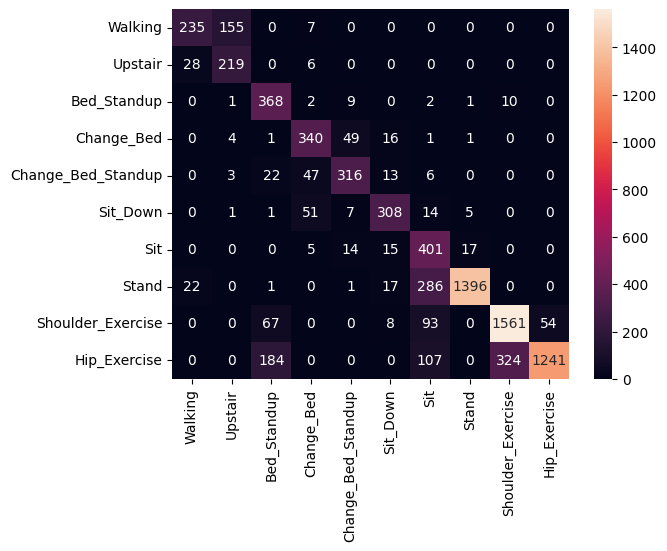

In [27]:
for missing_index, (all_test, all_pred) in all_test_pred.items():
    print("missing index", missing_index)
    all_test_with_label = [label_list[i] for i in all_test]
    all_pred_with_label = [label_list[i] for i in all_pred]

    cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
    sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [28]:

# print("precision_recall_fscore_support: ")
# print()
# print(*eng_label_list, sep=" "*4)
# print(*precision_recall_fscore_support(all_test_with_label, all_pred_with_label, labels=label_list), sep="\n")

precision_recall_fscore_support: 

Walking    Upstair    Bed_Standup    Change_Bed    Change_Bed_Standup    Sit_Down    Sit    Stand    Shoulder_Exercise    Hip_Exercise
[0.8245614  0.57180157 0.57142857 0.74235808 0.7979798  0.81697613
 0.44065934 0.98309859 0.8237467  0.95830116]
[0.59193955 0.86561265 0.93638677 0.82524272 0.77641278 0.79586563
 0.88716814 0.81021474 0.87549075 0.66864224]
[0.68914956 0.68867925 0.70973963 0.7816092  0.78704857 0.80628272
 0.58883994 0.88832326 0.84883089 0.78768645]
[ 397  253  393  412  407  387  452 1723 1783 1856]
